In [1]:
import numpy as np
import scipy as sp
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as p9
from statsmodels.stats.multitest import fdrcorrection

from sklearn import preprocessing
from sklearn import metrics
import networkx as nx
import mantel

import utils

import pickle

# 1 6 region

In [2]:
expr = pd.read_csv("../res/0.preprocessing/sample_expr.tsv", sep="\t", index_col=0)
info = pd.read_csv("../res/0.preprocessing/sample_info.tsv", sep="\t", index_col=0)

In [3]:
#expr_scale = pd.DataFrame(preprocessing.scale(expr.T, axis=0)).T
expr_scale = expr.copy()
corr_pr = expr_scale.corr(method='pearson')
corr_sp = expr_scale.corr(method='spearman')

upper_idx = np.triu(np.ones(shape=corr_pr.shape), 1).astype(bool)
r_pr_sp, p_pr_sp, _ = mantel.test(corr_pr.to_numpy()[upper_idx], corr_sp.to_numpy()[upper_idx], perms=10000, )
r_pr_sp, p_pr_sp

(0.9656681180769021, 0.0001)

In [4]:
region_group = {}
for i, r in enumerate(info["Region"]):
    if not r in region_group:
        region_group[r] = []
    region_group[r].append(i)
region_group = [ region_group[r] for r in region_group ]
region_group

corr_pr[corr_pr<0] = 0
pr_res = utils.significant_test_for_index(corr_pr, region_group, n_perm=1000)
pr_res[-2], pr_res[-1]

(array([0.068, 0.054, 0.048]), array([0.068, 0.068, 0.068]))

In [6]:
corr_sp[corr_sp<0] = 0
sp_res = utils.significant_test_for_index(corr_sp, region_group, n_perm=1000)
sp_res[-2], sp_res[-1]

(array([0.083, 0.078, 0.072]), array([0.083, 0.083, 0.083]))

In [7]:
pr_dat_boxplot = pd.DataFrame(pr_res[1], columns=["Strength fraction", "Conductance", "Normalized cut"]).melt(var_name="Index", value_name="Value")
pr_dat_scatter = pd.DataFrame([pr_res[0], pr_res[-1]], index=["Value", "FDR"]).T
pr_dat_scatter["Index"] = ["Strength fraction", "Conductance", "Normalized cut"]
pr_dat_scatter["y"] = pr_dat_boxplot.groupby(pr_dat_boxplot["Index"]).quantile(0.99).loc[pr_dat_scatter["Index"]].values + 0.01
pr_dat_scatter

,Value,FDR,Index,y
0,0.219267,0.068,Strength fraction,0.231947
1,5.079171,0.068,Conductance,5.114138
2,6.094682,0.068,Normalized cut,6.135382


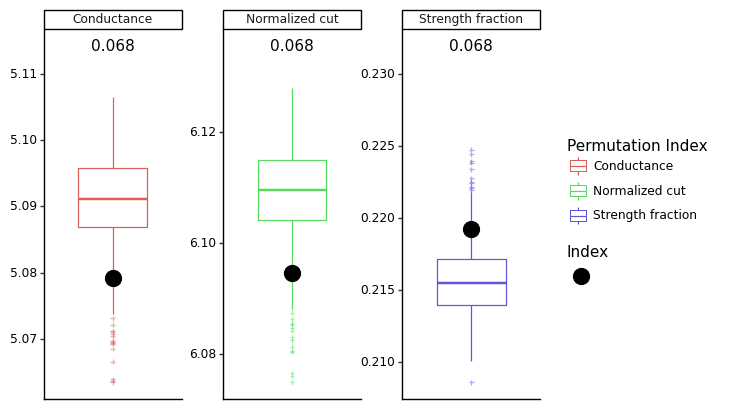

<ggplot: (8742087152080)>

In [8]:
pr_plot = ( p9.ggplot(p9.aes(x="Index", y="Value", color="Index", group="Index"), pr_dat_boxplot) 
  + p9.geom_boxplot(width=0.5, outlier_shape='+', outlier_alpha=0.5)
  + p9.geom_point(p9.aes(x="Index", y="Value", size=5), data=pr_dat_scatter, color="black", )
  + p9.geom_text(p9.aes(x="Index", y="y", label="FDR"), pr_dat_scatter, color="black")
  + p9.facet_wrap("~Index", nrow=1, ncol=3, scales="free")
  + p9.scale_color_discrete(name="Permutation Index")
  + p9.scale_size_continuous(name="Index", breaks=[5], labels=[" "])
  + p9.theme_classic()
  + p9.theme(subplots_adjust={'wspace': 0.30},
             axis_title=p9.element_blank(),
             axis_text_x=p9.element_blank(),
             axis_ticks_major_x=p9.element_blank(),
             axis_text=p9.element_text(color="black")
             
            )
)
p9.ggsave(pr_plot, "../res/2.pr_6region.pdf", units="in", width=6, height=4, verbose=False )
pr_plot

In [9]:
sp_dat_boxplot = pd.DataFrame(sp_res[1], columns=["Strength fraction", "Conductance", "Normalized cut"]).melt(var_name="Index", value_name="Value")
sp_dat_scatter = pd.DataFrame([sp_res[0], sp_res[-1]], index=["Value", "FDR"]).T
sp_dat_scatter["Index"] = ["Strength fraction", "Conductance", "Normalized cut"]
sp_dat_scatter["y"] = sp_dat_boxplot.groupby(sp_dat_boxplot["Index"]).quantile(0.99).loc[sp_dat_scatter["Index"]].values + 0.01
sp_dat_scatter

,Value,FDR,Index,y
0,0.219411,0.083,Strength fraction,0.232602
1,5.077928,0.083,Conductance,5.119628
2,6.093057,0.083,Normalized cut,6.141461


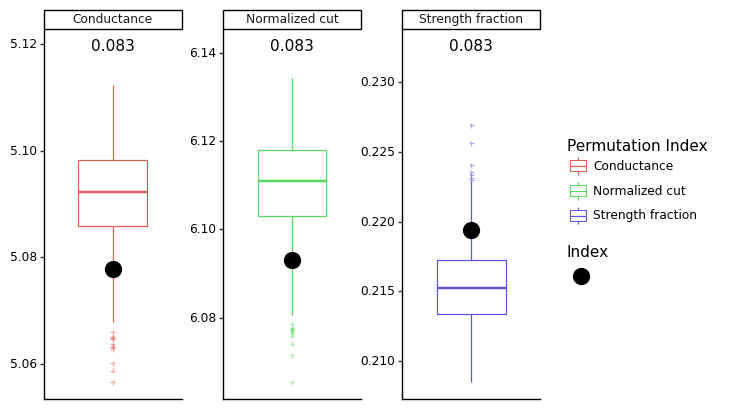

<ggplot: (8742103712464)>

In [10]:
sp_plot = ( p9.ggplot(p9.aes(x="Index", y="Value", color="Index", group="Index"), sp_dat_boxplot) 
  + p9.geom_boxplot(width=0.5, outlier_shape="+", outlier_alpha=0.5)
  + p9.geom_point(p9.aes(x="Index", y="Value", size=5), data=sp_dat_scatter, color="black", )
  + p9.geom_text(p9.aes(x="Index", y="y", label="FDR"), sp_dat_scatter, color="black")
  + p9.facet_wrap("~Index", nrow=1, ncol=3, scales="free")
  + p9.scale_color_discrete(name="Permutation Index")
  + p9.scale_size_continuous(name="Index", breaks=[5], labels=[" "])
  + p9.theme_classic()
  + p9.theme(subplots_adjust={'wspace': 0.30},
             axis_title=p9.element_blank(),
             axis_text_x=p9.element_blank(),
             axis_ticks_major_x=p9.element_blank(),
             axis_text=p9.element_text(color="black")
             
            )
)
p9.ggsave(sp_plot, "../res/2.sp_6region.pdf", units="in", width=6, height=4, verbose=False )
sp_plot

# 2 4 region

In [11]:
expr = pd.read_csv("../res/0.preprocessing/sample_expr.tsv", sep="\t", index_col=0)
info = pd.read_csv("../res/0.preprocessing/sample_info.tsv", sep="\t", index_col=0)

select_idx = info["Region"].isin(["PF", "PFG", "PG", "Opt"])
expr = expr.loc[:, select_idx]
info = info.loc[select_idx, :]

In [12]:
#expr_scale = pd.DataFrame(preprocessing.scale(expr.T, axis=0)).T
expr_scale = expr.copy()
corr_pr = expr_scale.corr(method='pearson')
corr_sp = expr_scale.corr(method='spearman')

upper_idx = np.triu(np.ones(shape=corr_pr.shape), 1).astype(bool)
r_pr_sp, p_pr_sp, _ = mantel.test(corr_pr.to_numpy()[upper_idx], corr_sp.to_numpy()[upper_idx], perms=10000, )
r_pr_sp, p_pr_sp

(0.962777680005712, 0.0001)

In [13]:
region_group = {}
for i, r in enumerate(info["Region"]):
    if not r in region_group:
        region_group[r] = []
    region_group[r].append(i)
region_group = [ region_group[r] for r in region_group ]
region_group

corr_pr[corr_pr<0] = 0
pr_res = utils.significant_test_for_index(corr_pr, region_group, n_perm=1000)
pr_res[-2], pr_res[-1]

(array([0.128, 0.13 , 0.123]), array([0.13, 0.13, 0.13]))

In [14]:
corr_sp[corr_sp<0] = 0
sp_res = utils.significant_test_for_index(corr_sp, region_group, n_perm=1000)
sp_res[-2], sp_res[-1]

(array([0.204, 0.172, 0.159]), array([0.204, 0.204, 0.204]))

In [15]:
pr_dat_boxplot = pd.DataFrame(pr_res[1], columns=["Strength fraction", "Conductance", "Normalized cut"]).melt(var_name="Index", value_name="Value")
pr_dat_scatter = pd.DataFrame([pr_res[0], pr_res[-1]], index=["Value", "FDR"]).T
pr_dat_scatter["Index"] = ["Strength fraction", "Conductance", "Normalized cut"]
pr_dat_scatter["y"] = pr_dat_boxplot.groupby(pr_dat_boxplot["Index"]).quantile(0.99).loc[pr_dat_scatter["Index"]].values + 0.01
pr_dat_scatter

,Value,FDR,Index,y
0,0.338573,0.13,Strength fraction,0.355174
1,3.061055,0.13,Conductance,3.089965
2,4.080730,0.13,Normalized cut,4.116646


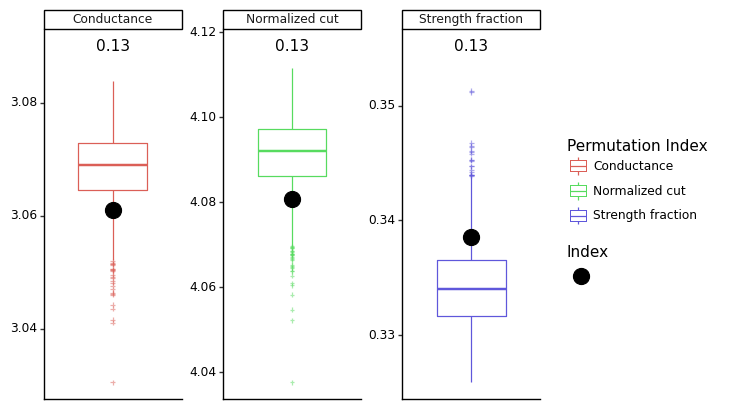

<ggplot: (8742087054532)>

In [16]:
pr_plot = ( p9.ggplot(p9.aes(x="Index", y="Value", color="Index", group="Index"), pr_dat_boxplot) 
  + p9.geom_boxplot(width=0.5, outlier_shape='+', outlier_alpha=0.5)
  + p9.geom_point(p9.aes(x="Index", y="Value", size=5), data=pr_dat_scatter, color="black", )
  + p9.geom_text(p9.aes(x="Index", y="y", label="FDR"), pr_dat_scatter, color="black")
  + p9.facet_wrap("~Index", nrow=1, ncol=3, scales="free")
  + p9.scale_color_discrete(name="Permutation Index")
  + p9.scale_size_continuous(name="Index", breaks=[5], labels=[" "])
  + p9.theme_classic()
  + p9.theme(subplots_adjust={'wspace': 0.30},
             axis_title=p9.element_blank(),
             axis_text_x=p9.element_blank(),
             axis_ticks_major_x=p9.element_blank(),
             axis_text=p9.element_text(color="black")
             
            )
)
p9.ggsave(pr_plot, "../res/2.pr_4region.pdf", units="in", width=6, height=4, verbose=False )
pr_plot

In [17]:
sp_dat_boxplot = pd.DataFrame(sp_res[1], columns=["Strength fraction", "Conductance", "Normalized cut"]).melt(var_name="Index", value_name="Value")
sp_dat_scatter = pd.DataFrame([sp_res[0], sp_res[-1]], index=["Value", "FDR"]).T
sp_dat_scatter["Index"] = ["Strength fraction", "Conductance", "Normalized cut"]
sp_dat_scatter["y"] = sp_dat_boxplot.groupby(sp_dat_boxplot["Index"]).quantile(0.99).loc[sp_dat_scatter["Index"]].values + 0.01
sp_dat_scatter

,Value,FDR,Index,y
0,0.337621,0.204,Strength fraction,0.357614
1,3.060076,0.204,Conductance,3.094649
2,4.079219,0.204,Normalized cut,4.122718


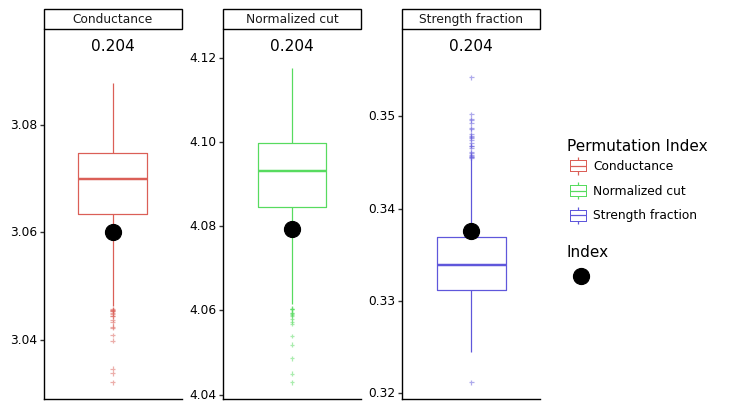

<ggplot: (8742091097067)>

In [18]:
sp_plot = ( p9.ggplot(p9.aes(x="Index", y="Value", color="Index", group="Index"), sp_dat_boxplot) 
  + p9.geom_boxplot(width=0.5, outlier_shape="+", outlier_alpha=0.5)
  + p9.geom_point(p9.aes(x="Index", y="Value", size=5), data=sp_dat_scatter, color="black", )
  + p9.geom_text(p9.aes(x="Index", y="y", label="FDR"), sp_dat_scatter, color="black")
  + p9.facet_wrap("~Index", nrow=1, ncol=3, scales="free")
  + p9.scale_color_discrete(name="Permutation Index")
  + p9.scale_size_continuous(name="Index", breaks=[5], labels=[" "])
  + p9.theme_classic()
  + p9.theme(subplots_adjust={'wspace': 0.30},
             axis_title=p9.element_blank(),
             axis_text_x=p9.element_blank(),
             axis_ticks_major_x=p9.element_blank(),
             axis_text=p9.element_text(color="black")
             
            )
)
p9.ggsave(sp_plot, "../res/2.sp_4region.pdf", units="in", width=6, height=4, verbose=False )
sp_plot